In [150]:
from datasets import load_dataset
import numpy as np
from collections import defaultdict
from tabulate import tabulate

In [151]:
# Load dataset
dataset = load_dataset("sst", "default")

In [152]:
# Naive Bayes training function
def train_naive_bayes(D, C):
    N_doc = len(D)
    logprior = {}
    loglikelihood = {}
    V = set()
    bigdoc = defaultdict(list)
    word_counts_per_class = defaultdict(lambda: defaultdict(int))

    # Calculate logprior and collect documents for each class
    for c in C:
        D_c = [doc_tokens for doc_tokens, cl in D if cl == c]
        N_c = len(D_c)
        logprior[c] = np.log(N_c / N_doc)
        for doc in D_c:
            bigdoc[c] += doc
            V.update(doc)
            for word in doc:
                word_counts_per_class[word][c] += 1

    V = list(V)

    # Calculate loglikelihood
    for w in V:
        for c in C:
            count_w_c = word_counts_per_class[w][c]
            loglikelihood[(w, c)] = np.log((count_w_c + 1) / (sum(word_counts_per_class[w].values()) + len(V)))

    return logprior, loglikelihood, V


# Naive Bayes testing function
def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    sum_scores = {c: logprior[c] for c in C}
    for word in testdoc:
        if word in V:
            for c in C:
                sum_scores[c] += loglikelihood.get((word, c), 0)
    return max(sum_scores, key=sum_scores.get)

In [153]:
# Define sentiment classes
classes = {
    0: "Very Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very Positive",
}

# Map dataset labels to sentiment classes
def map_dataset(data):
    if data <= 0.2:
        return 0  # very negative
    elif data <= 0.4:
        return 1  # negative
    elif data <= 0.6:
        return 2  # neutral
    elif data <= 0.8:
        return 3  # positive
    else:
        return 4  # very positive

# Convert dataset entries to tokens
def data_to_tokens(data):
    documents = []
    for entry in data:
        tokens = entry['tokens'].split("|")
        label = map_dataset(entry['label'])
        documents.append((tokens, label))
    return documents

In [154]:
# Prepare training and testing data
train_documents = data_to_tokens(dataset['train'])
test_documents = data_to_tokens(dataset['test'])

In [155]:
# Train Naive Bayes classifier
logprior, loglikelihood, vocab_list = train_naive_bayes(train_documents, [0, 1, 2, 3, 4])

# Test the classifier on the test dataset
correct_predictions = 0
total_predictions = len(test_documents)

# Initialize variables for precision, recall, and F1 score
true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)

for doc_tokens, actual_class in test_documents:
    predicted_class = test_naive_bayes(doc_tokens, logprior, loglikelihood, [0, 1, 2, 3, 4], vocab_list)
    if predicted_class == actual_class:
        true_positives[actual_class] += 1
        correct_predictions += 1
    else:
        false_positives[predicted_class] += 1
        false_negatives[actual_class] += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)

# Test the classifier on a sample document
random_phrase = "This movie was fantastic! I loved every minute of it."
random_score = np.random.uniform(0, 1)
actual_class = map_dataset(random_score)
predicted_class = test_naive_bayes(random_phrase.split(), logprior, loglikelihood, [0, 1, 2, 3, 4], vocab_list)
print("Random phrase:", random_phrase)
print("Predicted class:", predicted_class)
print("Actual class:", actual_class)

Accuracy: 0.36742081447963804
Random phrase: This movie was fantastic! I loved every minute of it.
Predicted class: 1
Actual class: 1


In [156]:
# Calculate precision, recall, and F1 score for each class
precision = {}
recall = {}
f1_score = {}

for c in classes:
    if true_positives[c] == 0:
        precision[c] = 0
        recall[c] = 0
        f1_score[c] = 0
    else:
        precision[c] = true_positives[c] / (true_positives[c] + false_positives[c])
        recall[c] = true_positives[c] / (true_positives[c] + false_negatives[c])
        f1_score[c] = 2 * (precision[c] * recall[c]) / (precision[c] + recall[c])

# Calculate macro-average precision, recall, and F1 score
macro_precision = sum(precision.values()) / len(precision)
macro_recall = sum(recall.values()) / len(recall)
macro_f1_score = sum(f1_score.values()) / len(f1_score)

# Convert precision, recall, and F1 score dictionaries to lists of tuples for tabulate
precision_table = [(classes[c], precision[c]) for c in classes]
recall_table = [(classes[c], recall[c]) for c in classes]
f1_score_table = [(classes[c], f1_score[c]) for c in classes]

# Add macro-average values to the tables
precision_table.append(("Macro-average", macro_precision))
recall_table.append(("Macro-average", macro_recall))
f1_score_table.append(("Macro-average", macro_f1_score))

# Print precision, recall, and F1 score tables
print("\nPrecision:")
print(tabulate(precision_table, headers=["Class", "Precision"], tablefmt="grid"))

print("\nRecall:")
print(tabulate(recall_table, headers=["Class", "Recall"], tablefmt="grid"))

print("\nF1 Score:")
print(tabulate(f1_score_table, headers=["Class", "F1 Score"], tablefmt="grid"))


Precision:
+---------------+-------------+
| Class         |   Precision |
+===============+=============+
| Very Negative |    0        |
+---------------+-------------+
| Negative      |    0.462611 |
+---------------+-------------+
| Neutral       |    0.666667 |
+---------------+-------------+
| Positive      |    0.312102 |
+---------------+-------------+
| Very Positive |    1        |
+---------------+-------------+
| Macro-average |    0.488276 |
+---------------+-------------+

Recall:
+---------------+------------+
| Class         |     Recall |
+===============+============+
| Very Negative | 0          |
+---------------+------------+
| Negative      | 0.576619   |
+---------------+------------+
| Neutral       | 0.0102828  |
+---------------+------------+
| Positive      | 0.864706   |
+---------------+------------+
| Very Positive | 0.00501253 |
+---------------+------------+
| Macro-average | 0.291324   |
+---------------+------------+

F1 Score:
+---------------+------

In [157]:
#comparison with sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Prepare training and testing data
train_texts = [' '.join(tokens) for tokens, _ in train_documents]
test_texts = [' '.join(tokens) for tokens, _ in test_documents]
train_labels = [label for _, label in train_documents]
test_labels = [label for _, label in test_documents]

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=1.0))
])

# Train the classifier
pipeline.fit(train_texts, train_labels)

# Predict on the test set
predicted_labels = pipeline.predict(test_texts)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy using scikit-learn:", accuracy)

Accuracy using scikit-learn: 0.4090497737556561


In [158]:
# Logistic regression
# Feature representation
def create_bigrams(text):
    bigrams = []
    for i in range(len(text) - 1):
        bigram = (text[i], text[i + 1])
        bigrams.append(bigram)
    return bigrams

def create_bigram_features(data):
    all_bigrams_set = set()
    bigram_counts = defaultdict(int)

    for doc in data:
        text = doc['tokens']
        doc_bigrams = create_bigrams(text)
        all_bigrams_set.update(doc_bigrams)
        for bigram in doc_bigrams:
            bigram_counts[bigram] += 1

    return list(all_bigrams_set), bigram_counts

def vectorize_features(data, vocabulary):
    X = np.zeros((len(data), len(vocabulary)), dtype=np.uint8)

    for i, doc in enumerate(data):
        text = doc['tokens']
        doc_bigrams = create_bigrams(text)
        for j, bigram in enumerate(vocabulary):
            if bigram in doc_bigrams:
                X[i, j] = 1

    return X

In [159]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.1, num_iterations=100):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_pred]
        return np.array(y_pred_class)

In [160]:
train_data = dataset["train"]
test_data = dataset["test"]
vocabulary, _ = create_bigram_features(train_data)

# Vectorize features
X_train = vectorize_features(train_data, vocabulary)
y_train = np.array([doc['label'] for doc in train_data])

# Initialize and train logistic regression model
my_logistic_model = MyLogisticRegression()
my_logistic_model.fit(X_train, y_train)

# Train accuracy
train_predictions = my_logistic_model.predict(X_train)
train_accuracy = np.mean(train_predictions == y_train)
print("Train Accuracy:", train_accuracy)

# Test data
X_test = vectorize_features(test_data, vocabulary)
y_test = np.array([doc['label'] for doc in test_data])

# Test accuracy
test_predictions = my_logistic_model.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.0029260299625468167
Test Accuracy: 0.0027149321266968325


In [161]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

# Preprocessing and data preparation
X_train_texts = [' '.join(doc[0]) for doc in train_documents]
y_train = [doc[1] for doc in train_documents]
X_test_texts = [' '.join(doc[0]) for doc in test_documents]
y_test = [doc[1] for doc in test_documents]

# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Vectorize the training and test data
X_train_vectorized = vectorizer.fit_transform(X_train_texts)
X_test_vectorized = vectorizer.transform(X_test_texts)

# Train logistic regression model
logistic_sklearn_model = LogisticRegression(max_iter=1000)
logistic_sklearn_model.fit(X_train_vectorized, y_train)

# Predictions
y_pred_logistic_regression = logistic_sklearn_model.predict(X_test_vectorized)
accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
print("Accuracy of Logistic Regression:", accuracy_logistic_regression)

# Compare with SGDClassifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train_vectorized, y_train)

y_pred_sgd = sgd_model.predict(X_test_vectorized)
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("Accuracy of SGDClassifier for Logistic Regression:", accuracy_sgd)

Accuracy of Logistic Regression: 0.35339366515837106
Accuracy of SGDClassifier for Logistic Regression: 0.3339366515837104


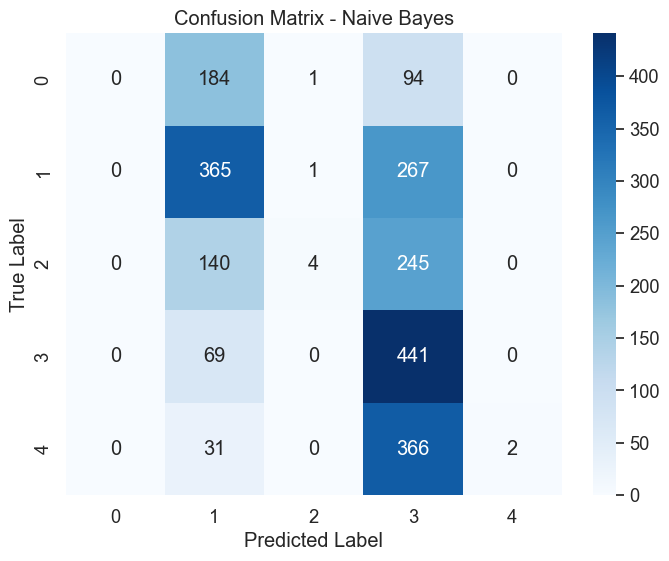

Metrics for Naive Bayes:
Precision: [0.         0.4626109  0.66666667 0.31210191 1.        ]
Recall: [0.         0.57661927 0.01028278 0.86470588 0.00501253]
F1 Score: [0.         0.51336146 0.02025316 0.45865835 0.00997506]
Macro-averaged Precision: 0.48827589547358985
Macro-averaged Recall: 0.2913240926665228
Macro-averaged F1 Score: 0.20044960719270127




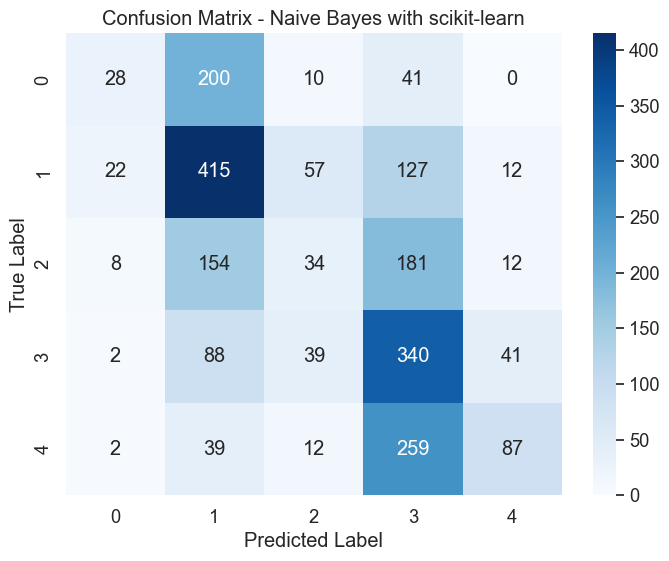

Metrics for Naive Bayes with scikit-learn:
Precision: [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
Recall: [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
F1 Score: [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]
Macro-averaged Precision: 0.41389699333828645
Macro-averaged Recall: 0.3456164032418666
Macro-averaged F1 Score: 0.3229872566299008




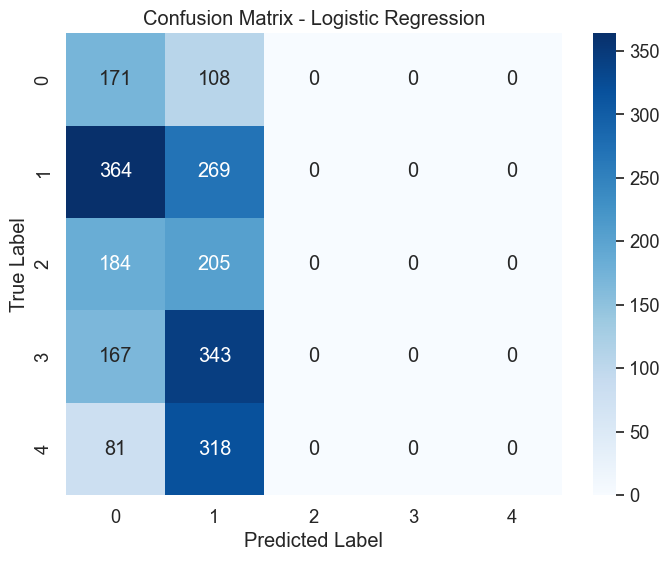

Metrics for Logistic Regression:
Precision: [0.17683557 0.21641191 0.         0.         0.        ]
Recall: [0.61290323 0.42496051 0.         0.         0.        ]
F1 Score: [0.27447833 0.28678038 0.         0.         0.        ]
Macro-averaged Precision: 0.07864949612348282
Macro-averaged Recall: 0.2075727462671355
Macro-averaged F1 Score: 0.11225174289068303




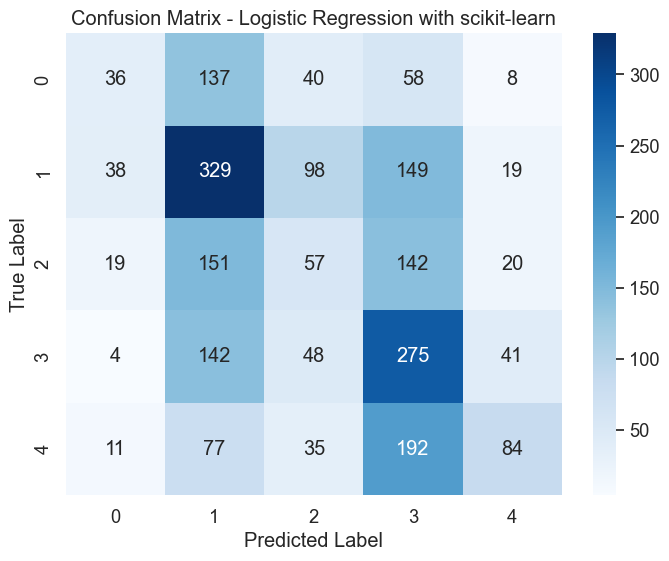

Metrics for Logistic Regression with scikit-learn:
Precision: [0.33333333 0.39354067 0.20503597 0.3370098  0.48837209]
Recall: [0.12903226 0.51974724 0.14652956 0.53921569 0.21052632]
F1 Score: [0.18604651 0.44792376 0.17091454 0.4147813  0.29422067]
Macro-averaged Precision: 0.35145837427152776
Macro-averaged Recall: 0.3090102116995101
Macro-averaged F1 Score: 0.3027773549296352




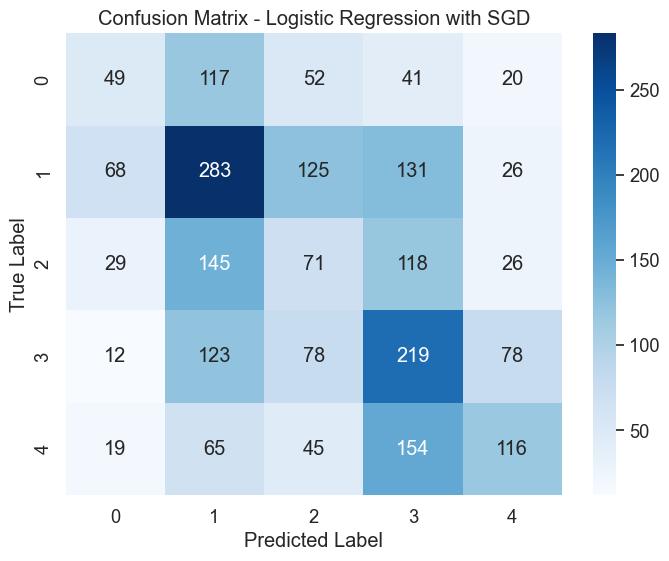

Metrics for Logistic Regression with SGD:
Precision: [0.27683616 0.38608458 0.19137466 0.33031674 0.43609023]
Recall: [0.17562724 0.44707741 0.18251928 0.42941176 0.29072682]
F1 Score: [0.21491228 0.41434846 0.18684211 0.37340153 0.34887218]
Macro-averaged Precision: 0.3241404745623996
Macro-averaged Recall: 0.30507250225204613
Macro-averaged F1 Score: 0.3076753127215218




In [162]:
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute metrics from confusion matrix
def compute_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]

    # Calculate precision, recall, and F1 score for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        precision[i] = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall[i] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Calculate macro-averaged precision, recall, and F1 score
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    return precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score

# Function to generate confusion matrix
def generate_confusion_matrix(true_labels, predicted_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    for true_label, predicted_label in zip(true_labels, predicted_labels):
        confusion_matrix[true_label, predicted_label] += 1

    return confusion_matrix

# Function to extract necessary information and generate confusion matrix for each model
def generate_confusion_matrix_for_model(true_labels, predicted_labels, num_classes, model_name):
    # Generate confusion matrix
    confusion_matrix = generate_confusion_matrix(true_labels, predicted_labels, num_classes)

    # Compute metrics
    precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score = compute_metrics(confusion_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print metrics
    print(f"Metrics for {model_name}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("Macro-averaged Precision:", macro_precision)
    print("Macro-averaged Recall:", macro_recall)
    print("Macro-averaged F1 Score:", macro_f1_score)
    print("\n")

# True labels and predicted labels for each model
# Replace true_labels and predicted_labels for Naive Bayes
true_labels_nb = [actual_label for _, actual_label in test_documents]
predicted_labels_nb = [test_naive_bayes(doc_tokens, logprior, loglikelihood, [0, 1, 2, 3, 4], vocab_list) for doc_tokens, _ in test_documents]

# Replace true_labels and predicted_labels for Naive Bayes with scikit-learn
true_labels_nb_sklearn = test_labels
predicted_labels_nb_sklearn = pipeline.predict(test_texts)

# Replace true_labels and predicted_labels for Logistic Regression
true_labels_lr = y_test
predicted_labels_lr = my_logistic_model.predict(X_test)

# Replace true_labels and predicted_labels for Logistic Regression with scikit-learn
true_labels_lr_sklearn = y_test
predicted_labels_lr_sklearn = logistic_sklearn_model.predict(X_test_vectorized)

# Replace true_labels and predicted_labels for Logistic Regression with SGD
true_labels_lr_sgd = y_test
predicted_labels_lr_sgd = sgd_model.predict(X_test_vectorized)

# Number of classes
num_classes = 5

# Generate confusion matrix and compute metrics for each model
generate_confusion_matrix_for_model(true_labels_nb, predicted_labels_nb, num_classes, "Naive Bayes")
generate_confusion_matrix_for_model(true_labels_nb_sklearn, predicted_labels_nb_sklearn, num_classes, "Naive Bayes with scikit-learn")
generate_confusion_matrix_for_model(true_labels_lr, predicted_labels_lr, num_classes, "Logistic Regression")
generate_confusion_matrix_for_model(true_labels_lr_sklearn, predicted_labels_lr_sklearn, num_classes, "Logistic Regression with scikit-learn")
generate_confusion_matrix_for_model(true_labels_lr_sgd, predicted_labels_lr_sgd, num_classes, "Logistic Regression with SGD")
